# Re-analysis on control WD data

#### Load New Libs
We were previously using an older version of RaceID (v3, but not bioconductor), and some marked changes have been applied since. We need to check for one of two things:
 - That we get the same clustering as before with the newer lib
 - That we get *better* clustering with the newer lib

In [1]:
install.packages("devtools")
library(devtools)
options(unzip="/usr/bin/unzip")
install_github("dgrun/RaceID3_StemID2_package")
library(RaceID)

Installing package into ‘/home/tetris/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
from URL https://api.github.com/repos/dgrun/RaceID3_StemID2_package/zipball/master
Installing RaceID
'/usr/lib64/R/bin/R' --no-site-file --no-environ --no-save --no-restore  \
  --quiet CMD INSTALL  \
  '/tmp/Rtmp28WkeD/devtools70f1585d13f/dgrun-RaceID3_StemID2_package-8cd2b55'  \
  --library='/home/tetris/R/x86_64-pc-linux-gnu-library/3.5' --install-tests 

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”Warning message:
“'rgl_init' failed, running with rgl.useNULL = TRUE”

### Noisy clusters in previous
The clustering actually seemed better when MT genes were kept within the analysis, but this is not the way that Sagar did it, and nor is it correct to keep them in if they are not useful to the analysis. Certain genes were filtered out (via FGenes or CGenes?) that led to much better clustering and I need to recreate this.

In [2]:
 source_matrix <- readRDS("source/cleaned_matrix.rds")
 data.frame(data=dim(source_matrix), row.names=c("Genes", "Cells"))

,data
Genes,11237
Cells,768


### Test initial clustering (previous: minexpr=2, mintotal=900)

In [178]:
sc <- SCseq(source_matrix)

## Methods

In [188]:
# runs after comptsne and compfr
plotallmaps <- function(sob, dotsize=1, height=7){
    options(repr.plot.height = height)
    par(cex=dotsize,mfrow=c(2,2))
    plotmap(sob, fr=F, final=F)
    mtext("tSNE initial", side=3)
    plotmap(sob, fr=T, final=F)
    mtext("FR initial", side=3)
    plotmap(sob, fr=F, final=T)
    mtext("tSNE final", side=3)
    plotmap(sob, fr=T, final=T)
    mtext("FR final", side=3)
}

# all in one script, uses most defaults
generateAll <- function(sob, filterlist){
    sob2 <- do.call(filterdata, c(sob, filterlist))
    print(data.frame(dim(sob2@ndata), row.names = c("Genes","Cells")))

    sob2 <- compdist(sob2)
    xxx <- capture.output(sob2 <- clustexp(sob2))

    par(mfrow=c(2,2))
    plotsaturation(sob2, disp=F)
    plotsaturation(sob2, disp=T)
    plotjaccard(sob2)

    message("Num. Initial clusters = ", sob2@cluster$clb$nc)
    sob2 <- findoutliers(sob2)
    message("Num. Final clusters = ", max(sob2@cpart))

    par(mfrow=c(2,2))
    plotbackground(sob2)
    plotsensitivity(sob2)
    plotoutlierprobs(sob2)

    #clustheatmap(sob2)

    sob2 <- comptsne(sob2)
    sob2 <- compfr(sob2)
    return(sob2)
}

# Sorted list of most expressive genes
contributingVariance <- function(sc_obj, topN = 20){
    mat <- as.data.frame(as.matrix(sc_obj@ndata))
    mat.rsums <- sort(rowSums(mat), decreasing=T)
    mat.totalsum <- sum(mat.rsums)
    mat.totalsum.n <- sum(head(mat.rsums, topN))
    message("Top ", topN, " genes account for ", sprintf("%.1f", 100 * mat.totalsum.n / mat.totalsum), "% of the variance")
    return(head(100 * mat.rsums / mat.totalsum, topN))
}


## MinExpr = 2, MinTotal = 900

      dim.sob2.ndata.
Genes           11237
Cells             474


Num. Initial clusters = 7


find outliers in cluster 7 
merging outliers 11 
determine final clustering partition 18 


Num. Final clusters = 18


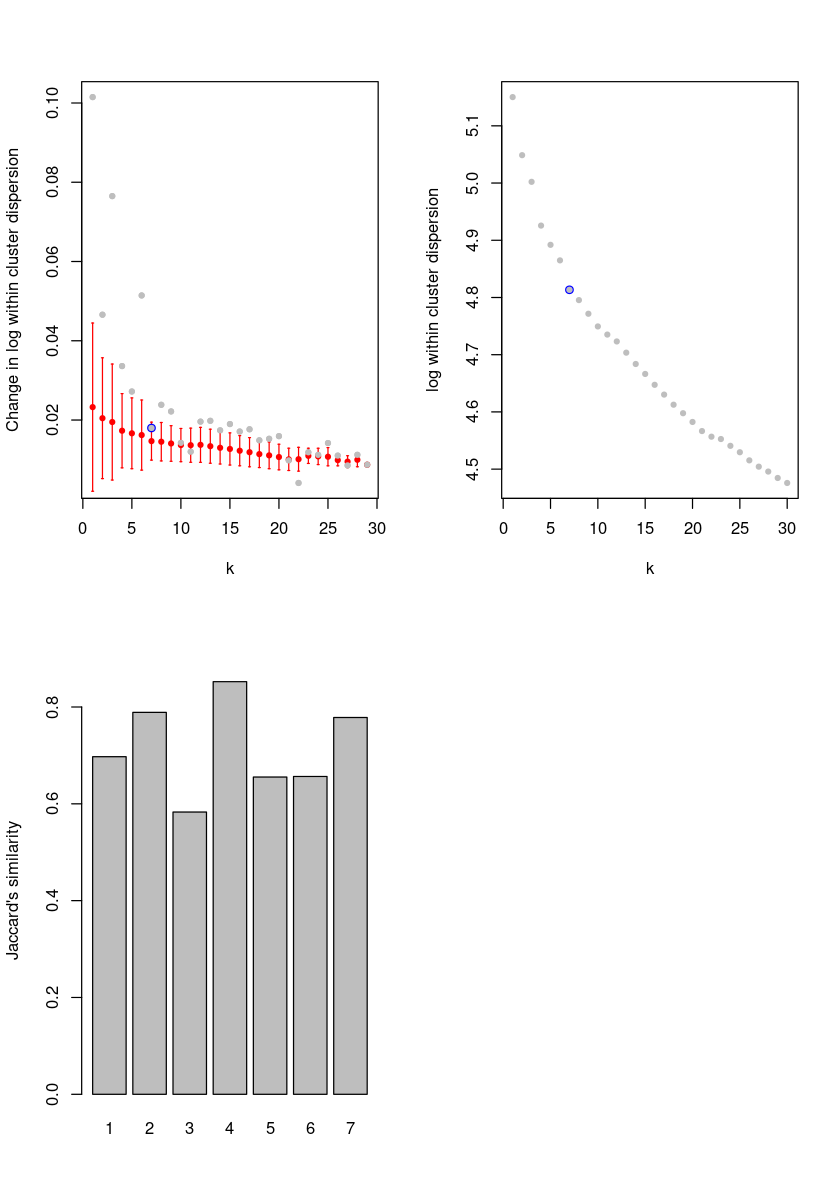

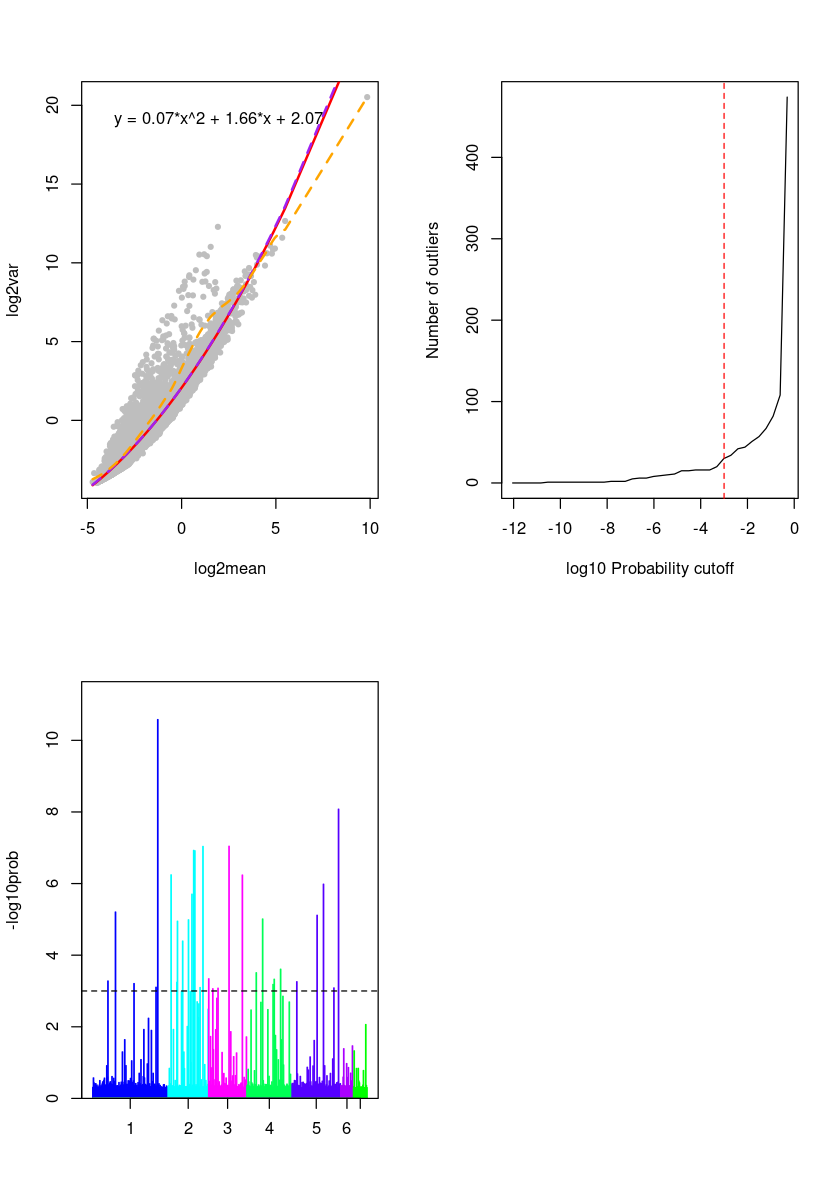

In [186]:
sc2_900 <- generateAll(sc, list(minexpr=2, mintotal=900))

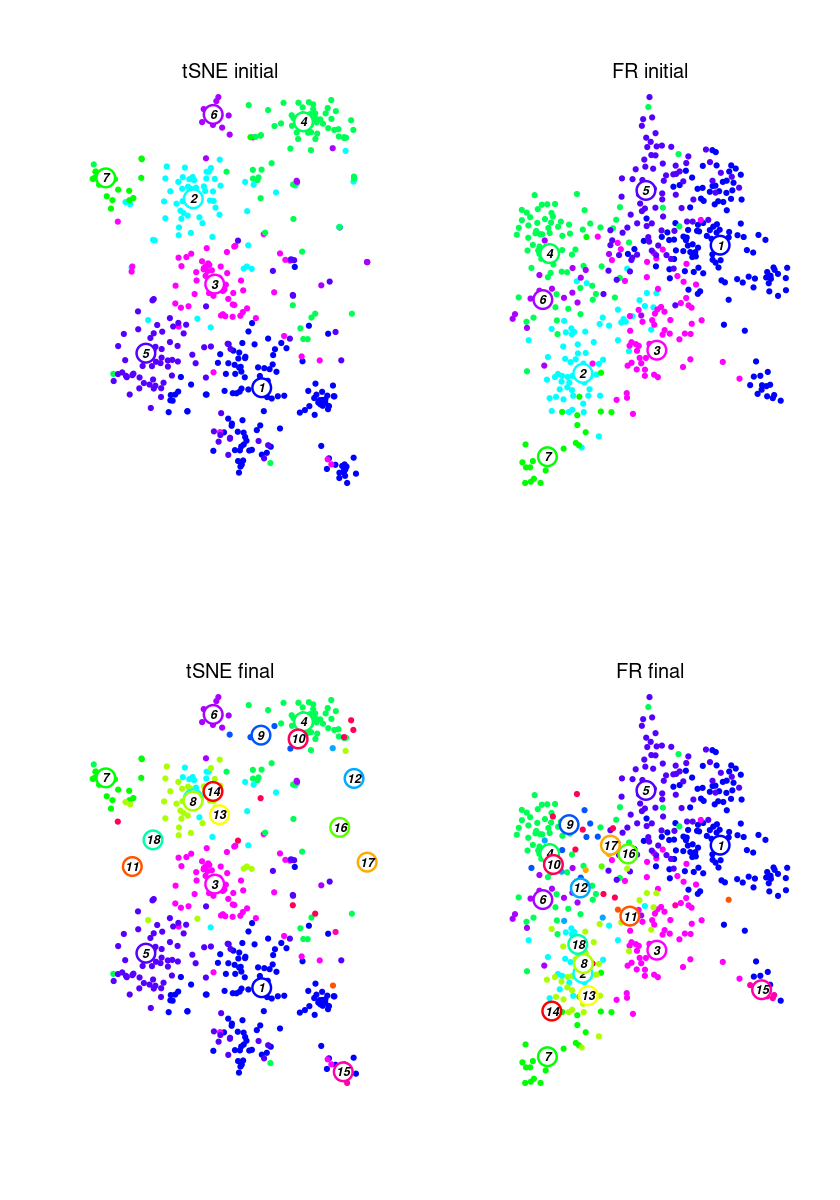

In [187]:
plotall(sc2_900, 1, 10)

This is reasonably messy clustering, with too many single outlier cells scattered around.
Let us inspect the top N DE genes and see where they are expressed

In [189]:
contributingVariance(sc2_900, 20)

Top 20 genes account for 23.8% of the variance


NC_002333.4       NC_002333.17             mt-co2             mt-co1 
        16.4189012          0.8843309          0.8075303          0.5643307 
            mt-co3            mt-atp6 ENSDARG00000070212               gch1 
         0.5546694          0.5387842          0.4899558          0.3921790 
ENSDARG00000041627             tmsb4x             mt-nd4          marcksl1b 
         0.3809928          0.3133584          0.2801347          0.2773958 
            neu3.3             mt-cyb           eef1a1l1             tuba1c 
         0.2503591          0.2454699          0.2434934          0.2421048 
            gpm6aa              actb2               otpa         CT027638.1 
         0.2363758          0.2355502          0.2338051          0.1975860

We can definitely see that NC_002333.4 is over-expressed. We can confirm this with an exptsne plot to see which clusters it appears in.

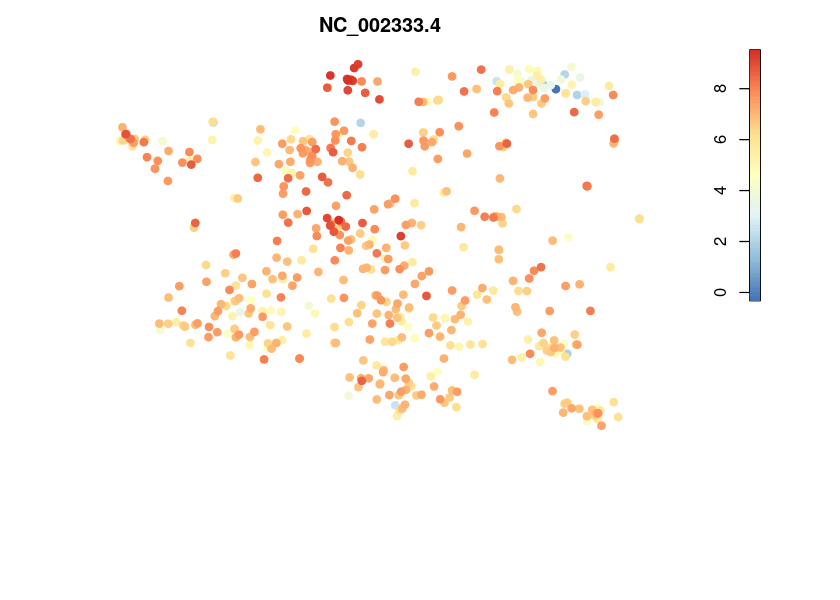

In [190]:
options(repr.plot.height = 5)
plotexpmap(sc2_900, "NC_002333.4", logsc=T)

### Repeat analysis without NC_002333.4 and mito genes out

In [94]:
library(data.table)
investigateClusters <- function(sc_obj, clust_nums, pval=1e-10){  
    return(rbindlist(lapply(clust_nums, FUN=function(n){
            table <- clustdiffgenes(sc_obj, n, pvalue=pval)            
            deb <- cbind(n, rownames(table), table)
            rownames(deb) <- NULL
            return(deb)        
    })))
           
    #name_table <- cbind(lapply(clust_nums, FUN=function(n){
    #    rownames(tab2[[n]])
    #}))
    #colnames(name_table) <- c("Cluster", "Sig. Genes")
    #
    #return(list(
    #   table = formatted_tab,
    #   names = name_table
    #))
}

In [97]:
tabs <- investigateClusters(sc2_900, 1:7)
#cdiff <- clustdiffgenes(sc2_900, 1)

In [101]:
#tabs[tabs$padj < 1e-20,]


n,rownames(table),mean.ncl,mean.cl,fc,pv,padj
1,chodl,0.2207656,1.5345758,6.95115399,1.376475e-51,1.241442e-47
1,gch1,2.0964307,8.1282827,3.87720079,3.464912e-47,1.562502e-43
1,ddc,0.7345874,3.1876232,4.33933855,1.123711e-43,3.378250e-40
1,apoeb,1.2705551,0.1172406,0.09227506,5.673979e-40,1.279340e-36
1,slc6a3,0.3371562,1.5925721,4.72354426,2.491967e-38,4.495011e-35
1,ENSDARG00000089963,1.1598485,0.1099879,0.09482956,1.983848e-35,2.982055e-32
1,AL935210.1,1.1320900,0.1250359,0.11044694,1.757178e-33,2.263998e-30
1,apoc1,1.2328288,0.1596451,0.12949491,2.515138e-33,2.835503e-30
1,th,0.7525023,2.6249402,3.48828190,2.358420e-31,2.363399e-28
1,sulf2b,0.6659036,2.0704539,3.10923994,2.733609e-25,2.465442e-22


In [85]:
tab2 <- lapply(1:2, FUN=function(n){
    table <- clustdiffgenes(sc2_900, n)            
    deb <- cbind(n, rownames(table), table)
    rownames(deb) <- NULL
    return(deb)        
})

In [93]:

rbindlist(tab2)

n,rownames(table),mean.ncl,mean.cl,fc,pv,padj
1,chodl,0.2207656,1.5345758,6.95115399,1.376475e-51,1.241442e-47
1,gch1,2.0964307,8.1282827,3.87720079,3.464912e-47,1.562502e-43
1,ddc,0.7345874,3.1876232,4.33933855,1.123711e-43,3.378250e-40
1,apoeb,1.2705551,0.1172406,0.09227506,5.673979e-40,1.279340e-36
1,slc6a3,0.3371562,1.5925721,4.72354426,2.491967e-38,4.495011e-35
1,ENSDARG00000089963,1.1598485,0.1099879,0.09482956,1.983848e-35,2.982055e-32
1,AL935210.1,1.1320900,0.1250359,0.11044694,1.757178e-33,2.263998e-30
1,apoc1,1.2328288,0.1596451,0.12949491,2.515138e-33,2.835503e-30
1,th,0.7525023,2.6249402,3.48828190,2.358420e-31,2.363399e-28
1,sulf2b,0.6659036,2.0704539,3.10923994,2.733609e-25,2.465442e-22


In [89]:
tab2

n,rownames(table),mean.ncl,mean.cl,fc,pv,padj
1,chodl,0.2207656,1.5345758,6.95115399,1.376475e-51,1.241442e-47
1,gch1,2.0964307,8.1282827,3.87720079,3.464912e-47,1.562502e-43
1,ddc,0.7345874,3.1876232,4.33933855,1.123711e-43,3.378250e-40
1,apoeb,1.2705551,0.1172406,0.09227506,5.673979e-40,1.279340e-36
1,slc6a3,0.3371562,1.5925721,4.72354426,2.491967e-38,4.495011e-35
1,ENSDARG00000089963,1.1598485,0.1099879,0.09482956,1.983848e-35,2.982055e-32
1,AL935210.1,1.1320900,0.1250359,0.11044694,1.757178e-33,2.263998e-30
1,apoc1,1.2328288,0.1596451,0.12949491,2.515138e-33,2.835503e-30
1,th,0.7525023,2.6249402,3.48828190,2.358420e-31,2.363399e-28
1,sulf2b,0.6659036,2.0704539,3.10923994,2.733609e-25,2.465442e-22
